In [54]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict

In [1]:
viratPath = 'D:\Files\Datasets\VIRAT'
framesPerVideo = 8

In [26]:
class EventInfo():
    def __init__(self, eventType, duration, startFrame, endFrame):
        self.eventType = int(eventType)
        self.duration = int(duration)
        self.startFrame = int(startFrame)
        self.endFrame = int(endFrame)        

In [99]:
def getCroppedClips():

    clips = []
    clipLabels = []

    for videoName in sorted(os.listdir(os.path.join(viratPath, 'videos'))):
        video = cv2.VideoCapture(os.path.join(viratPath, 'videos', videoName))
        video.set(cv2.CAP_PROP_POS_FRAMES, 0)
        success, image = video.read()
        f = open(os.path.join(viratPath, 'labels', videoName.split('.')[0] + '.viratdata.events.txt'))
        labelList = f.read().split('\n')[:-1]
        f.close()
        labelList = [l.split(' ')[:-1] for l in labelList]
        labelInfo = {}
        labelDict = defaultdict(dict)
        for l in labelList:
            if l[0] not in labelInfo:
                labelInfo[l[0]] = EventInfo(l[1], l[2], l[3], l[4])
            labelDict[l[0]][int(l[5])] = [int(e) for e in l[6:]]
        for k in labelInfo:
            print("Processing eventID %s" % k)
            clip = np.zeros((framesPerVideo, 3, 240, 320), dtype=np.uint8)
            frameNumbers = [round(labelInfo[k].startFrame + i * (labelInfo[k].duration - 1.0) / (framesPerVideo - 1)) for i in range(framesPerVideo)]
            #print(frameNumbers)

            for i, n in enumerate(frameNumbers):
                xmin, ymin, xlen, ylen = labelDict[k][n]  
                print(xmin, ymin, xlen, ylen)
                
                if xlen / ylen > 1.5:
                    ymin = max(round(ymin + ylen / 2.0 - (0.75 * xlen) / 2.0), 0) # 0.75 is 240 / 320 - height to width ratio
                    ylen = round(xlen * 0.75)
                    ymin = min(ymin, image.shape[0] - ylen)

                else:
                    xmin = max(round(xmin + xlen / 2.0 - (4. / 3. * ylen) / 2.0), 0)
                    xlen = round(ylen * 4. / 3.)
                    xmin = min(xmin, image.shape[1] - xlen)
                
                video.set(cv2.CAP_PROP_POS_FRAMES, n)
                success, image = video.read()
                if success:

                    bbox = image[ymin:ymin + ylen, xmin:xmin + xlen]
                    bbox = cv2.resize(bbox, (320, 240))
                    clip[i] = np.swapaxes(np.swapaxes(bbox, 0, 2), 1, 2)

                    if i == len(frameNumbers) - 1:
                        fig, ax = plt.subplots(figsize=(8, 6))
                        ax.imshow(image)
                        rect = mpatches.Rectangle((xmin, ymin), xlen, ylen,
                                      fill=False, edgecolor='red', linewidth=2)
                        ax.add_patch(rect)
                        ax.set_axis_off()
                        plt.tight_layout()
                        plt.show()

                else:
                    print('Error while reading frame %d in video %s' % (n, videoName))

            clips.append(clip)
            clipLabels.append(labelInfo[k].eventType)
            
    return (clips, clipLabels)

In [97]:
def getBlurredClips():

    clips = []
    clipLabels = []

    for videoName in sorted(os.listdir(os.path.join(viratPath, 'videos'))):
        video = cv2.VideoCapture(os.path.join(viratPath, 'videos', videoName))
        video.set(cv2.CAP_PROP_POS_FRAMES, 0)
        success, image = video.read()
        f = open(os.path.join(viratPath, 'labels', videoName.split('.')[0] + '.viratdata.events.txt'))
        labelList = f.read().split('\n')[:-1]
        f.close()
        labelList = [l.split(' ')[:-1] for l in labelList]
        labelInfo = {}
        labelDict = defaultdict(dict)
        for l in labelList:
            if l[0] not in labelInfo:
                labelInfo[l[0]] = EventInfo(l[1], l[2], l[3], l[4])
            labelDict[l[0]][int(l[5])] = [int(e) for e in l[6:]]
        for k in labelInfo:
            print("Processing eventID %s" % k)
            clip = np.zeros((framesPerVideo, 3, 240, 320), dtype=np.uint8)
            frameNumbers = [round(labelInfo[k].startFrame + i * (labelInfo[k].duration - 1.0) / (framesPerVideo - 1)) for i in range(framesPerVideo)]
            #print(frameNumbers)

            xminClip, yminClip, xmaxClip, ymaxClip = image.shape[1], image.shape[0], 0, 0

            for i, n in enumerate(frameNumbers): 
                xmin, ymin, xlen, ylen = labelDict[k][n]
                xminClip = min(xminClip, xmin)
                yminClip = min(yminClip, ymin)
                xmaxClip = max(xmaxClip, xmin + xlen)
                ymaxClip = max(ymaxClip, ymin + ylen)

            xlenClip = xmaxClip - xminClip
            ylenClip = ymaxClip - yminClip

            if xlenClip / ylenClip > 1.5:
                yminClip = max(round(yminClip + ylenClip / 2.0 - (0.75 * xlenClip) / 2.0), 0) # 0.75 is 240 / 320 - height to width ratio
                ylenClip = round(xlenClip * 0.75)
                yminClip = min(yminClip, image.shape[0] - ylenClip)

            else:
                xminClip = max(round(xminClip + xlenClip / 2.0 - (4. / 3. * ylenClip) / 2.0), 0)
                xlenClip = round(ylenClip * 4. / 3.)
                xminClip = min(xminClip, image.shape[1] - xlenClip)

            xmaxClip = xminClip + xlenClip
            ymaxClip = yminClip + ylenClip

            print("X: %d Y: %d Res: %d x %d" % (xminClip, yminClip, xlenClip, ylenClip))

            for i, n in enumerate(frameNumbers):
                xmin, ymin, xlen, ylen = labelDict[k][n]  
                print(xmin, ymin, xlen, ylen)
                video.set(cv2.CAP_PROP_POS_FRAMES, n)
                success, image = video.read()
                if success:

                    bbox = image[yminClip:ymaxClip, xminClip:xmaxClip]
                    blurredBbox = cv2.GaussianBlur(bbox, (25, 25), 0)  
                    mask = np.zeros((ylenClip, xlenClip, 3), dtype=np.bool)
                    mask[ymin - yminClip : ymin - yminClip + ylen, xmin - xminClip : xmin - xminClip + xlen] = True
                    finalBbox = np.where(mask, bbox, blurredBbox)

                    finalBbox = cv2.resize(finalBbox, (320, 240))
                    clip[i] = np.swapaxes(np.swapaxes(finalBbox, 0, 2), 1, 2)

                    if i == len(frameNumbers) - 1:
                        fig, ax = plt.subplots(figsize=(8, 6))
                        ax.imshow(image)
                        rect = mpatches.Rectangle((xminClip, yminClip), xlenClip, ylenClip,
                                      fill=False, edgecolor='red', linewidth=2)
                        ax.add_patch(rect)
                        ax.set_axis_off()
                        plt.tight_layout()
                        plt.show()

                else:
                    print('Error while reading frame %d in video %s' % (n, videoName))

            clips.append(clip)
            clipLabels.append(labelInfo[k].eventType)
            
    return (clips, clipLabels)

In [ ]:
clips, clipLabels = getBlurredClips()

In [ ]:
clipsCropped, clipLabelsCropped = getCroppedClips()

9


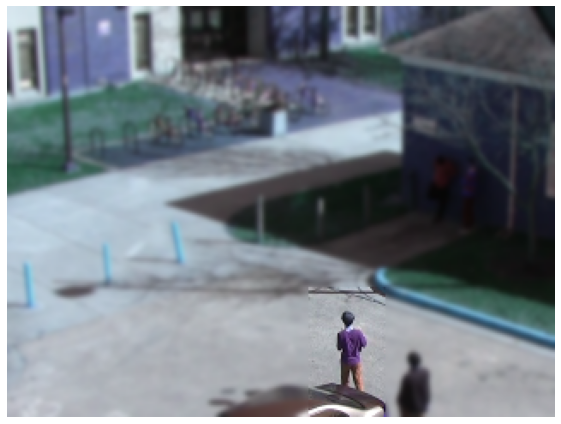

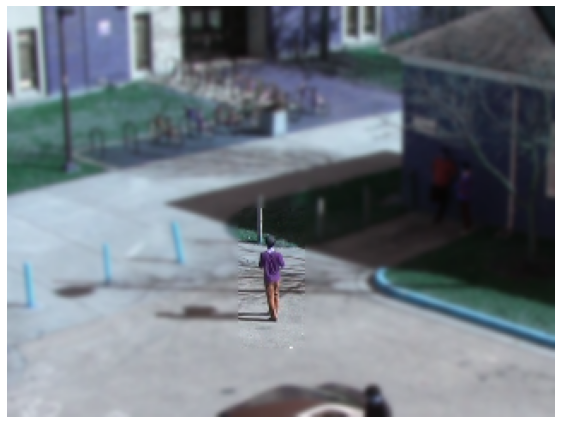

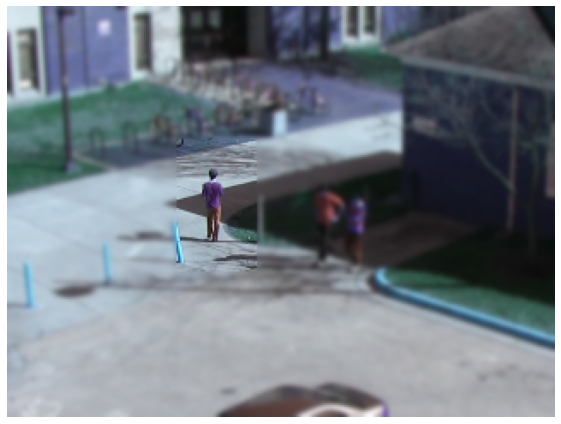

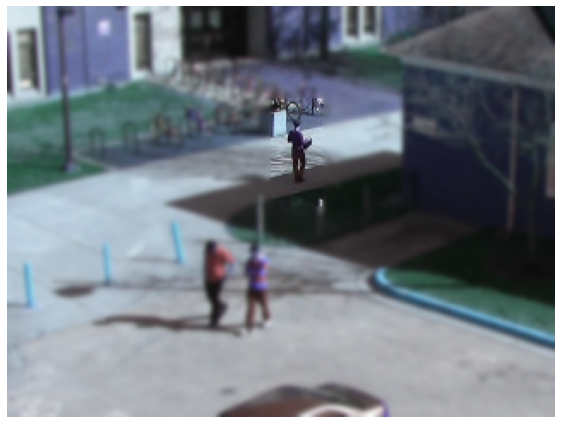

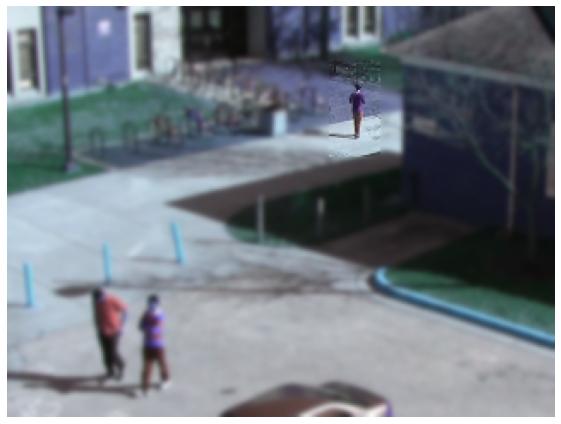

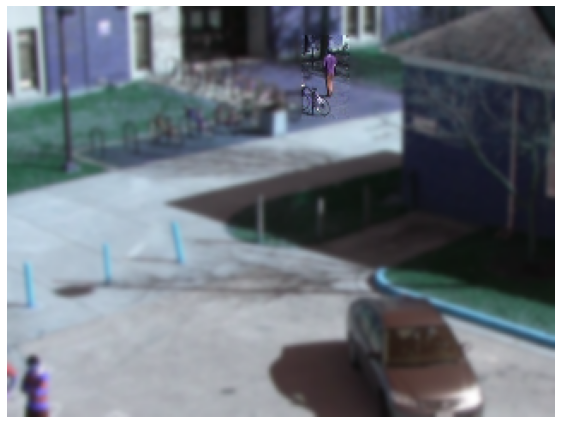

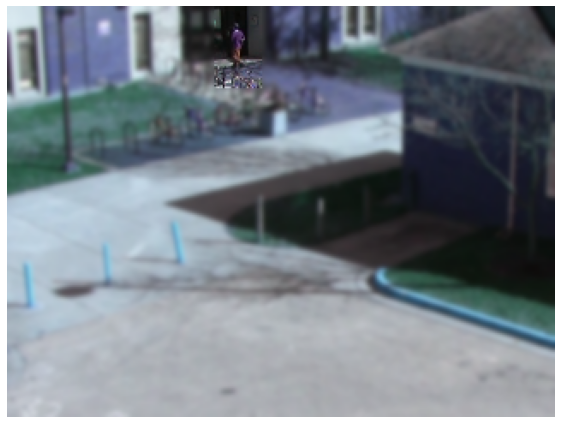

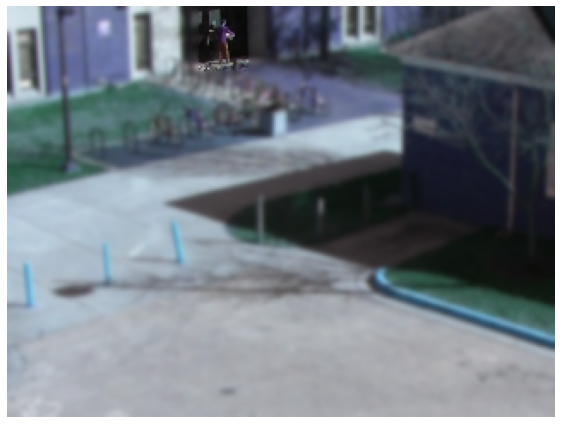

In [92]:
i = 65
print(clipLabels[i])
for c in clips[i]:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(np.swapaxes(np.swapaxes(c, 0, 2), 0, 1))
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

9


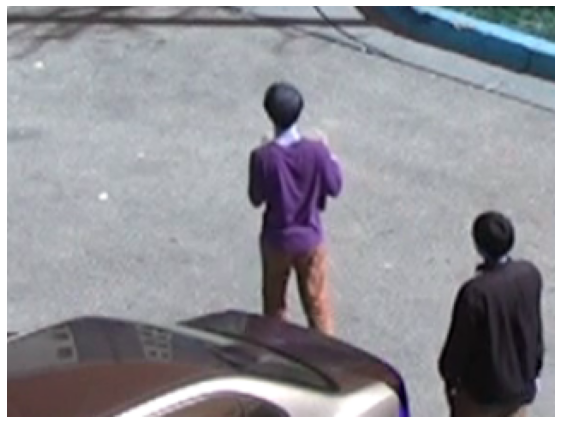

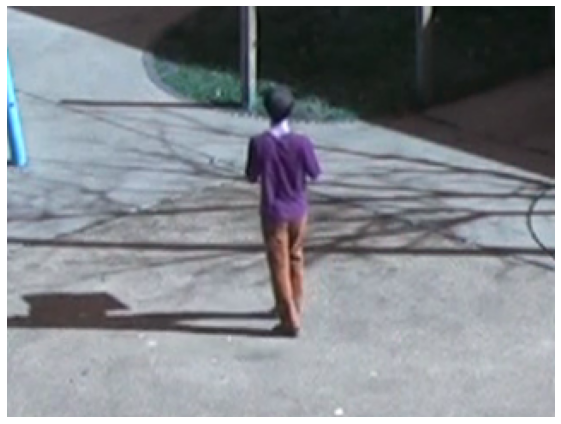

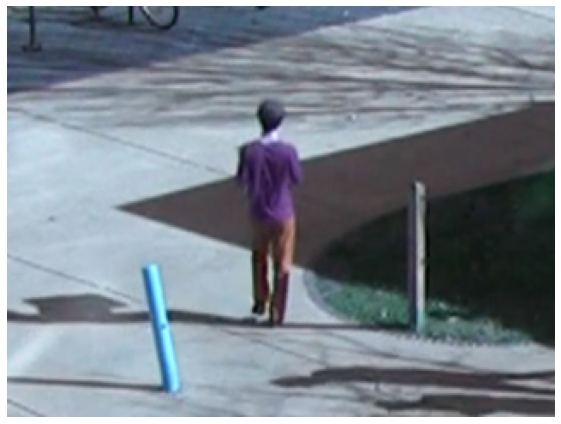

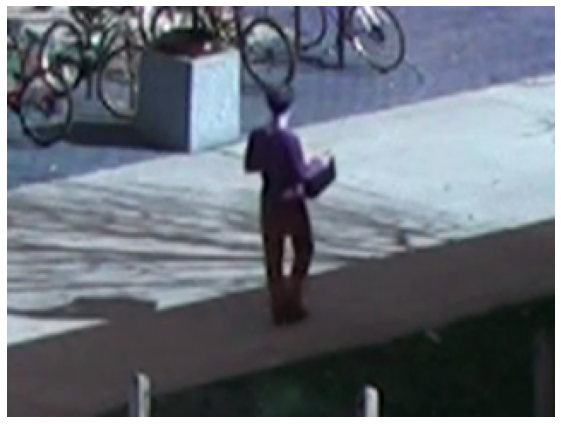

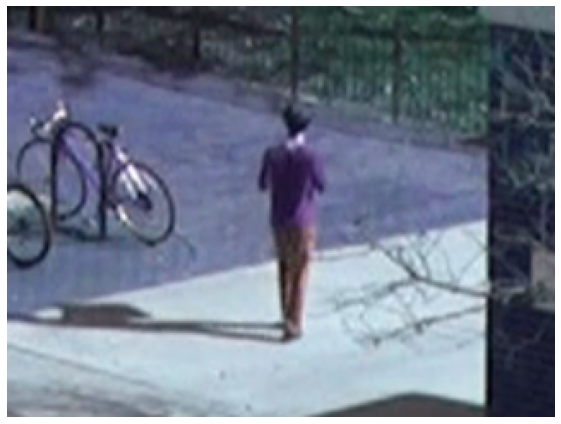

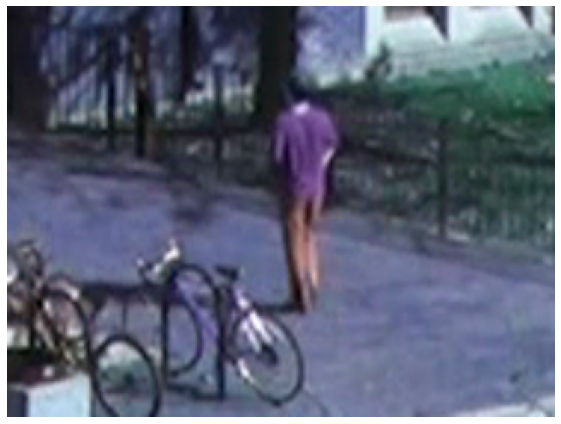

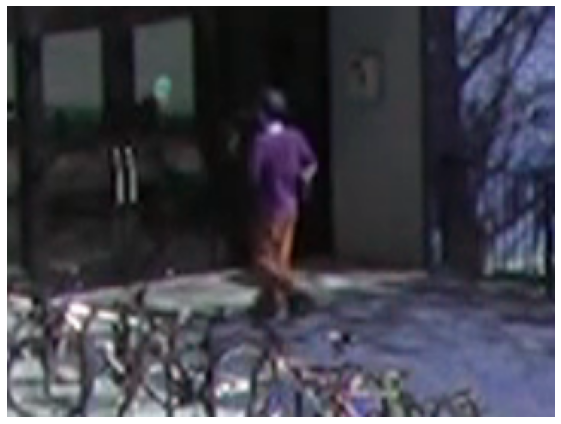

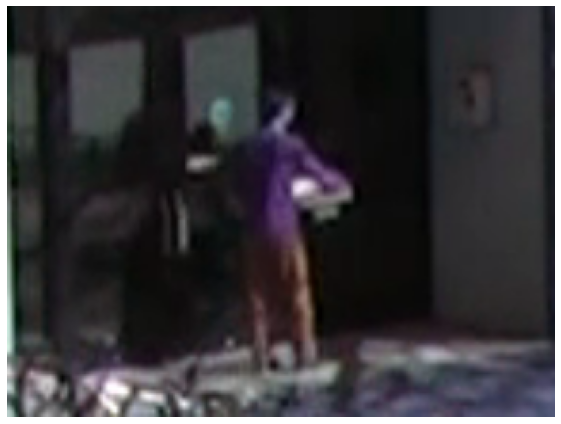

In [101]:
i = 65
print(clipLabelsCropped[i])
for c in clipsCropped[i]:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(np.swapaxes(np.swapaxes(c, 0, 2), 0, 1))
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()